# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


# import statements and misc. functions

In [1]:
# import statements
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def show_image(img, gray=True, title='image'):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 7))
    if gray == True:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title, fontsize=20)

## Calibrate Camera

Find object points and image points

In [3]:
## load calibration images
chess_images = glob.glob('camera_cal/calibration*.jpg')

## create object points 
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

## create lists to use in camera calibration
obj_points = []
image_points = []

for image in chess_images:
    
    ## convert to grayscale
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if corners were found, add obj and image points
    if ret == True:
        obj_points.append(objp)
        image_points.append(corners)
        
        # draw and display corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey()
    
# cv2.destroyAllWindows()    

Calculate camera matrix and distortion coefficients

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, image_points, (1280, 720), None, None)

# Undistort function

In [5]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Thresholding functions

functions to take various thresholds: x gradient, y gradient, magnitude, direction, and multiple colorspaces

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise Exception('Orient must be x or y')
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

In [7]:
## must be jpg, not png 

def hls_thresh(img, channel='h', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    if channel == 'h':
        selected_channel = hls[:,:,0]
    elif channel == 'l':
        selected_channel = hls[:,:,1]
    elif channel == 's':
        selected_channel = hls[:,:,2]
    else:
        raise Exception('Channel must be h, l, or s')
    
    binary_output = np.zeros_like(selected_channel)
    binary_output[(selected_channel >= thresh[0]) & (selected_channel <= thresh[1])] = 1
    
    return binary_output

In [8]:
## must be jpg, not png

def bgr_thresh(img, channel='r', thresh=(0,255)):
    
    if channel == 'r':
        selected_channel = img[:,:,2]
    elif channel == 'g':
        selected_channel = img[:,:,1]
    elif channel == 'b':
        selected_channel = img[:,:,0]
    else:
        raise Exception('Channel must be r, g, or b')
    
    binary_output = np.zeros_like(selected_channel)
    binary_output[(selected_channel >= thresh[0]) & (selected_channel <= thresh[1])] = 1
    
    return binary_output

Testing threshold values

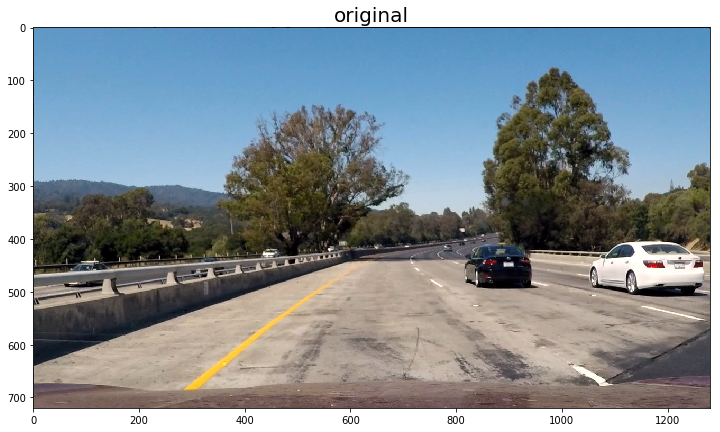

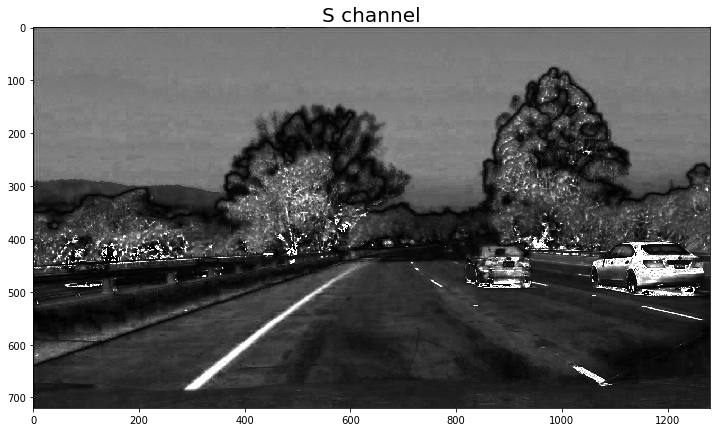

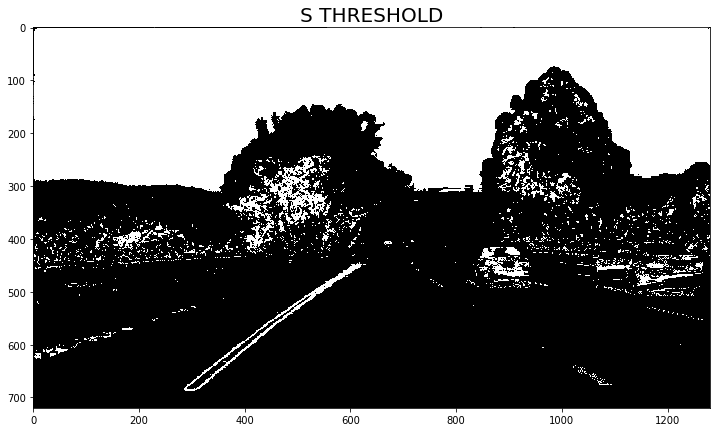

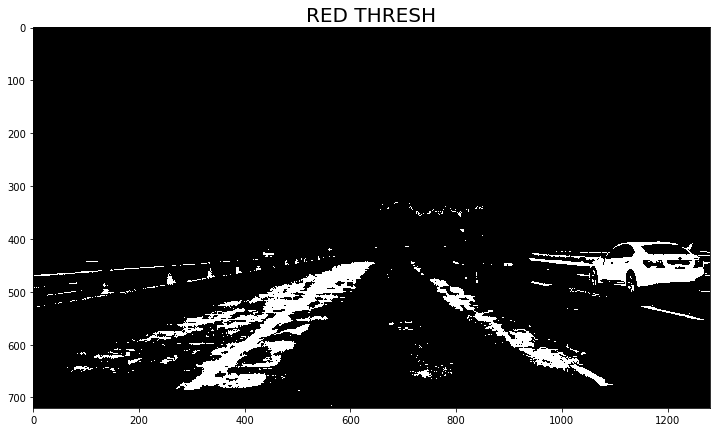

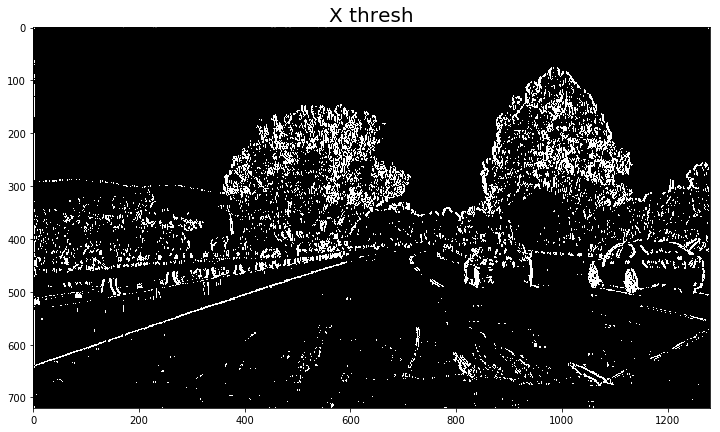

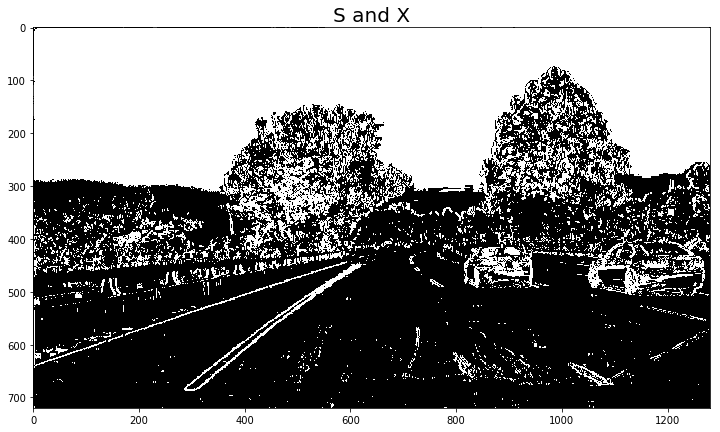

In [9]:
# choose image
test_images = glob.glob('test_images/*.jpg')
num = 2
img = cv2.imread(test_images[num])

# transform/threshold image
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

sobel_x = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(20, 255))
R_thresh = bgr_thresh(img, channel='r', thresh=(200,255))
S_thresh = hls_thresh(img, channel='s', thresh=(100, 240))
combined = np.zeros_like(sobel_x)
combined[(S_thresh == 1) | (sobel_x == 1)] = 1

# display images
show_image(img, title='original')
show_image(hls[:,:,2], title='S channel')
show_image(S_thresh, gray=True, title='S THRESHOLD')
show_image(R_thresh, gray=True, title='RED THRESH')
show_image(sobel_x, gray=True, title='X thresh')
# show_image(sobel_x, gray=True, title='x thresh')

show_image(combined, gray=True, title='S and X')

# Perspective transform

change perspective to bird's eye view to see lane lines as parallel

In [10]:
# input values: np.float32([[width, height], [w,h], [w,h], [w,h]])
# order: top_left, top_right, bottom_right, bottom_left

def warp_perspective(image, src, dest):
    image_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dest)
    M_inv = cv2.getPerspectiveTransform(dest, src)
    img = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_NEAREST)
    
    return img, M_inv

# TESTING
Test src and dest values

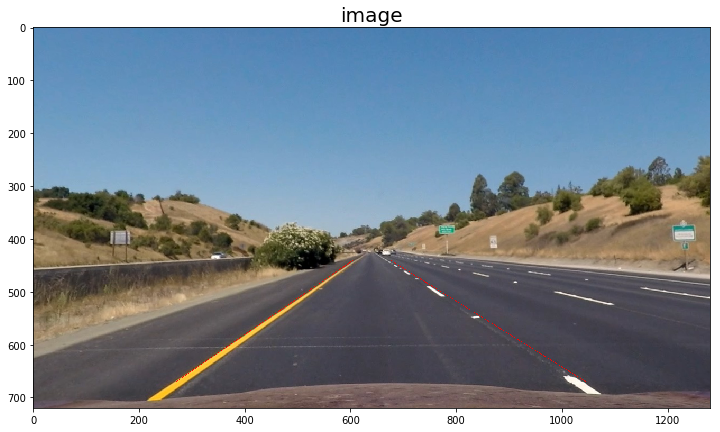

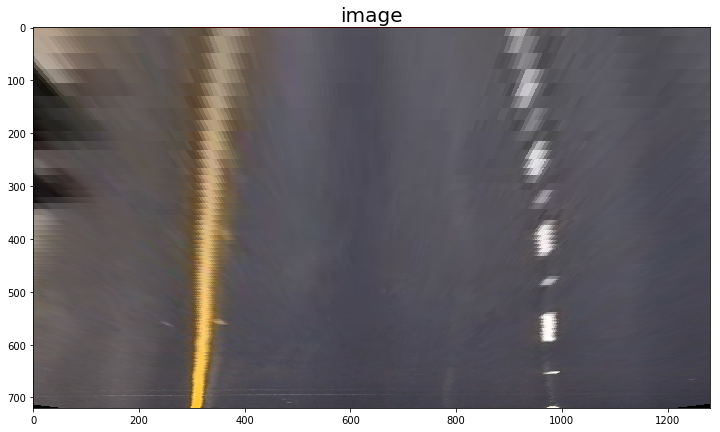

In [11]:
# choose image to load
test_images = glob.glob('test_images/*.jpg')
num = 0
img = cv2.imread(test_images[num])

# undistort image
undistorted = undistort(img, mtx, dist)

# define source points
tls = [605, 440]
trs = [675, 440]
brs = [1045, 670]
bls = [270, 670]

# define destination points
tld = [300,0]
trd = [1000,0]
brd = [1000,img.shape[0]]
bld = [300,img.shape[0]]

# define src and dest as np.float32 array
src = np.float32([tls, trs, brs, bls])
dest = np.float32([tld, trd, brd, bld])

# warp image
warped, M_inv = warp_perspective(undistorted, src, dest)

# define polygon to draw
poly = np.int32(src)
poly2 = np.int32(dest)

# draw lines on each image
cv2.polylines(undistorted, [poly], True, (0,0,255))
cv2.polylines(warped, [poly2], True, (0,0,255))


show_image(undistorted)
show_image(warped)

# Detecting Lane Lines


Find histogram peaks to locate starting x values of each lane

In [12]:
# INPUT: warped binary image 

def hist_peak(image):
    half = image.shape[0] // 2
    bottom_half = image[half:, :]
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

Set up sliding window search and polynomial fit

In [13]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


In [14]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

#     return out_img
    return left_fitx, right_fitx, ploty

In [15]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### create lane indices based on area around previous polynomial fit
    ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Draw Lane Lines

In [16]:
def draw_lines(binary_warp, image, M_inv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

# Video Processing

In [ ]:
# define Line class to track lines frame by frame
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [17]:
def process_image(image):
    # undistort image
    undistorted = undistort(image, mtx, dist)
    
    # threshold using Red channel and X gradient
    sobel_x = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=5, thresh=(20, 40))
    S_thresh = hls_thresh(undistorted, channel='s', thresh=(100, 240))
    combined = np.zeros_like(sobel_x)
    combined[(S_thresh == 1) | (sobel_x == 1)] = 1
    
    # warp perspective to bird's eye view
    binary_warped, M_inv = warp_perspective(combined, src, dest)
    
    # fit poly to lane lines
    left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
    
    # draw lines on image
    out_img = draw_lines(binary_warped, image, M_inv, left_fitx, right_fitx, ploty)
    
    
    return out_img

Test pipeline on test images

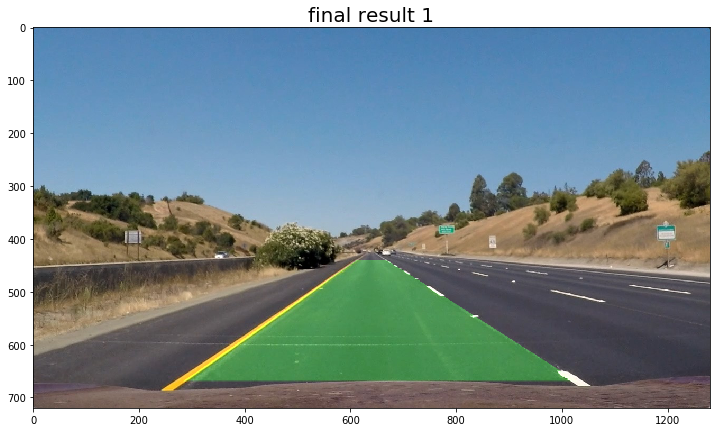

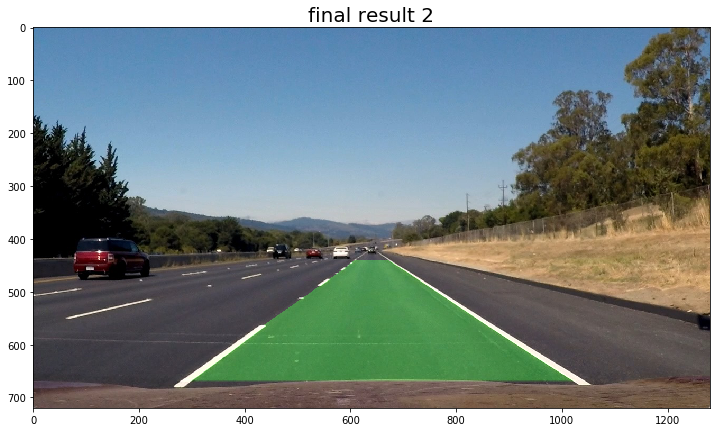

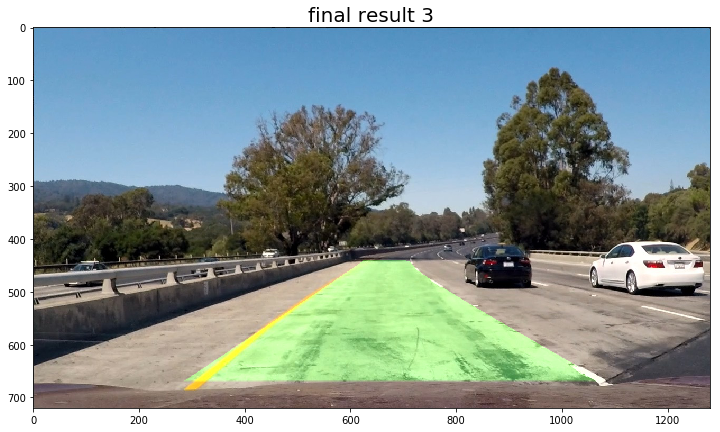

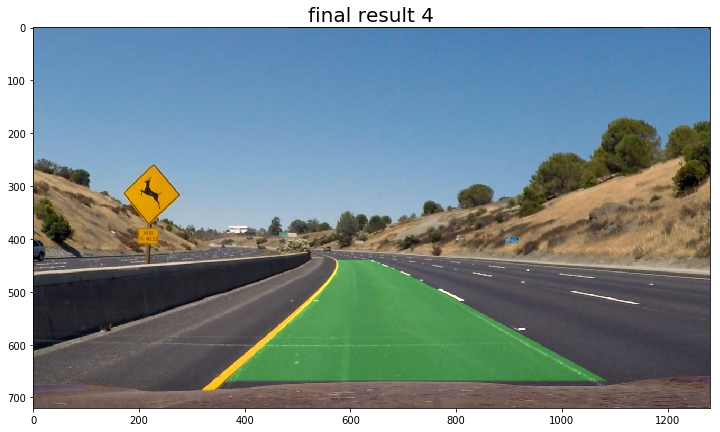

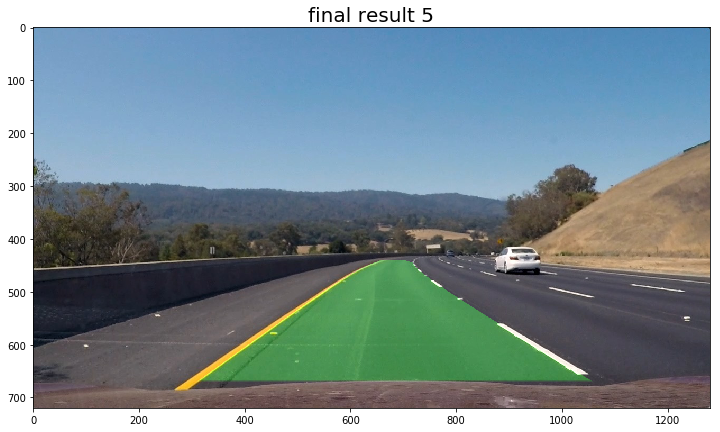

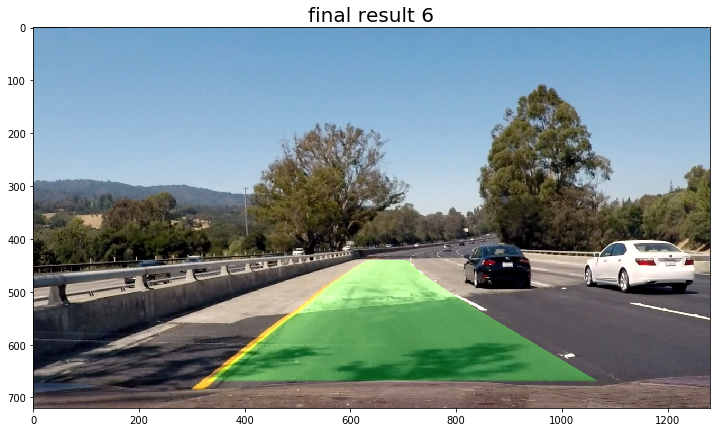

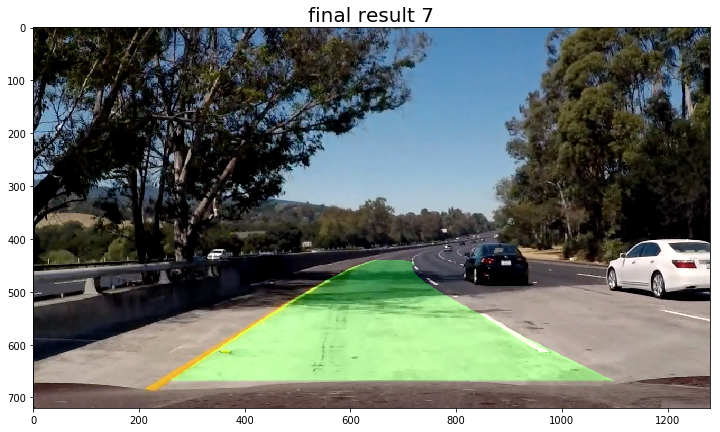

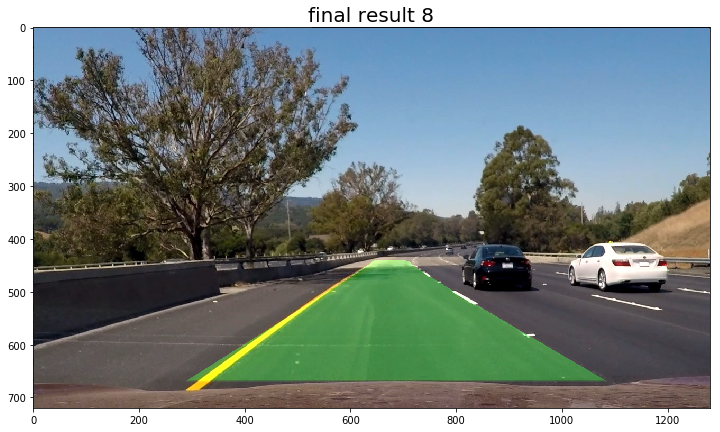

In [18]:
test_images = glob.glob('test_images/*.jpg')

for i,img in enumerate(test_images):
    image = cv2.imread(img)
    out_img = process_image(image)
    show_image(out_img, title='final result {}'.format(i+1))

In [21]:
vid_output = 'output_images/TESTING.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video output_images/TESTING.mp4
[MoviePy] Writing video output_images/TESTING.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:25<00:00,  6.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/TESTING.mp4 

Wall time: 3min 26s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))